In [2]:
pip install torch torchtext torchdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 53.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
# Save dataset
os.system('wget -O train_data.csv "https://docs.google.com/spreadsheets/d/176-KrOP8nhLpoW91UnrOY9oq_-I0XYNKS1zmqIErFsA/gviz/tq?tqx=out:csv&sheet=train_data.csv" -q')
os.system('wget -O val_data.csv "https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv" -q')
os.system('wget -O test_data.csv "https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv" -q')

0

In [5]:
import pandas as pd
df_train = pd.read_csv('train_data.csv')
df_valid = pd.read_csv('val_data.csv')
df_test = pd.read_csv('test_data.csv')

In [6]:
df_train.head()

,review,sentiment
0,I've watched this documentary twice - and alth...,positive
1,This is probably the worst movie I've seen in ...,negative
2,Superb story of a dedicated young teacher who ...,positive
3,<br /><br />Spoilers<br /><br />I'm going to b...,negative
4,"What can be said, really... ""The Tenant"" is a ...",positive


In [7]:
# Prepare data as X, Y
Xd, Yd = df_train.review.values.tolist(), df_train.sentiment.values.tolist()
Xv, Yv = df_valid.review.values.tolist(), df_valid.sentiment.values.tolist()
Xt, Yt = df_test.review.values.tolist(), df_test.sentiment.values.tolist()

sentiment = ['negative', 'positive']
Yd = [sentiment.index(y) for y in Yd]
Yv = [sentiment.index(y) for y in Yv]
Yt = [sentiment.index(y) for y in Yt]

## Rule based classification

In [8]:
# Extract features
def extract_features(X):

    feats = {'good_count': 0, 'bad_count': 0, 'bias': 1}
    words = X.split(' ')
    pos_words = ['good', 'great', 'excellent', 'positive', 'love', 'like',
                 'awesome', 'amazing', 'wonderful', 'best', 'better',
                 'beautiful', 'nice', 'fantastic', 'superb',
                 'incredible', 'perfect', 'well', 'fun', 'enjoy',
                 'enjoyable', 'enjoyed', 'enjoying', 'enjoyment']

    neg_words = ['hate', 'bad', 'horrible', 'awful', 'terrible', 'mess', 'frustating', 'frustatingly',
                 'worst', 'dumb', 'poor']

    for x in words:
        if x in pos_words:
            feats['good_count'] = feats.get('good_count', 0) + feats['bias']
        if x in neg_words:
            feats['bad_count'] = feats.get('good_count', 0) + feats['bias']
    return feats

def predict(X, w):
    feats = extract_features(X)
    score = 0
    for f in feats:
        score += feats[f] * w[f]
    return 1 if score > 0 else 0

def get_feature_weights():
    return {'good_count': 1.0, 'bad_count': -1.0, 'bias': 0.5}

def accuracy(Y_true, Y_pred):
    correct = 0.0
    total = len(Y_true)
    assert total == len(Y_pred)

    for i in range(total):
        if Y_true[i] == Y_pred[i]:
            correct += 1

    if total > 0:
        return 100.0 * correct / total
    return 0.0


In [9]:
feats_wt = get_feature_weights()
predictions = []

for x in Xt:
    y = predict(x, feats_wt)
    predictions.append(y)

print(accuracy(Yt, predictions))

60.475


In [10]:
from sklearn.linear_model import LogisticRegression
def get_learnable_wt(Xd, Yd):
    feats_name = list(extract_features(Xd[0]).keys())
    all_feats = []
    for x in Xd:
        feats = []
        feat_dict = extract_features(x)
        for f in feats_name:
            feats.append(feat_dict[f])
        all_feats.append(feats)

    clf = LogisticRegression(fit_intercept=False, random_state = 42).fit(all_feats, Yd)
    coeffs = clf.coef_[0]
    coffs_dict = {feats_name[i]: coeffs[i] for i in range(len(feats_name))}
    return coffs_dict

In [11]:
feats_wt_logistic = get_learnable_wt(Xd, Yd)
predictions = []

for x in Xt:
    y = predict(x, feats_wt_logistic)
    predictions.append(y)

print("Accuracy on Logistic Regression : ",accuracy(Yt, predictions))

Accuracy on Logistic Regression :  66.7


(-2.0, 2.0)

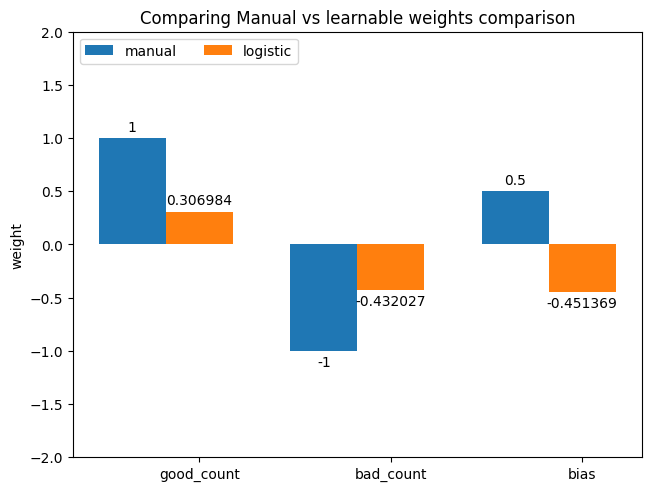

In [12]:
import matplotlib.pyplot as plt
import numpy as np

feats_names = list(feats_wt_logistic.keys())
manual_wt = [feats_wt[f] for f in feats_names]
logistic_wt = [feats_wt_logistic[f] for f in feats_names]

wt_dict = {'manual': manual_wt, 'logistic': logistic_wt}
x = np.arange(len(feats_names))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained');

for attribute, measurement in wt_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('weight')
ax.set_title('Comparing Manual vs learnable weights comparison')
ax.set_xticks(x + width, feats_names)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(-2, 2)

## Using Bag of Words

In [13]:
import collections

def word_to_idx(X, k = 1000):

    all_text = ' '.join(X)
    words = all_text.split()
    word_counts = collections.Counter(words)
    top_k_words = [word for word,_ in word_counts.most_common(k)]
    #print(top_k_words)
    word_idx = {word: idx for idx, word in enumerate(top_k_words)}

    return word_idx

In [14]:
def extract_features_bow(X, word_idx):
    features = {word: 0 for word in word_idx}
    words = X.split()
    for word in words:
        if word in word_idx:
            features[word] += 1
    return features

In [15]:
samples = [
    "When is the money due ?",
    "When are the TAs' office hours ?",
    "How hard is the job ?",
]
word_idx = word_to_idx(samples)
features = extract_features_bow(samples[0]+samples[1]+samples[2], word_idx)
for f in features:
    print(f,"\t", features[f])

the 	 3
? 	 1
When 	 1
is 	 2
money 	 1
due 	 1
are 	 1
TAs' 	 1
office 	 1
hours 	 1
How 	 0
hard 	 1
job 	 1


In [16]:
def learnable_word_to_idx(X, Y):

    word_idx = word_to_idx(X)
    feats_names = list(word_idx.keys())

    all_feats = []
    for x in X:
        f = []
        feats_dict = extract_features_bow(x, word_idx)

        for name in feats_names:
            f.append(feats_dict[name])
        all_feats.append(f)

    clf = LogisticRegression(fit_intercept = False, random_state = 42).fit(all_feats, Y)
    coeffs = clf.coef_[0]
    coeffs_dict = {feats_names[i]: coeffs[i] for i in range(len(feats_names))}

    return coeffs_dict

In [17]:
def predict_bow(X, feature_wt):
    features = extract_features_bow(X, feature_wt)
    score = 0
    for f_name, f_value in features.items():
        score = score + f_value * feature_wt[f_name]
        #print(feature_wt[f_name])#f_name, f_value, score)

    return 1 if score > 0 else 0

In [18]:
import warnings
warnings.filterwarnings('ignore')

learned_feature_wt = learnable_word_to_idx(Xd, Yd)
print("Learned feature weights :\n", list(learned_feature_wt.items())[:5])
preds = []
for x in Xt:
    y = predict_bow(x, learned_feature_wt)
    preds.append(y)

print("Accuracy on logistic regression on bow : ",accuracy(Yt, preds))

Learned feature weights :
 [('the', -0.004318629454279685), ('a', -0.021810056533700096), ('and', 0.06340806439469476), ('of', 0.024746934626418984), ('to', -0.0029263171888667555)]
Accuracy on logistic regression on bow :  81.575


In [19]:
most_positive = sorted(learned_feature_wt, key=learned_feature_wt.get, reverse=True)[:5]
most_negative = sorted(learned_feature_wt, key=learned_feature_wt.get, reverse=False)[:5]

print("Most positive words : ", most_positive)
print("Most negative words : ", most_negative)

Most positive words :  ['excellent', 'amazing', 'favorite', 'perfect', 'wonderful']
Most negative words :  ['waste', 'worst', 'poorly', 'fails', 'poor']


## Word2Vec

Word2Vec model has Continuous bag of word and Skipgram architectures.

In [38]:
!pip uninstall torchtext
!pip install torchtext

  Using cached torchtext-0.18.0-cp310-cp310-manylinux1_x86_64.whl.metadata (7.9 kB)
Using cached torchtext-0.18.0-cp310-cp310-manylinux1_x86_64.whl (2.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [22]:
pip install torch==2.0.0 torchtext==0.15.1

  Using cached torch-2.0.0-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177

In [1]:
import os
from functools import partial
from typing import Union, Tuple

from torchtext._internal.module_utils import is_module_available
from torchtext.data.datasets_utils import (
    _wrap_split_argument,
    _create_dataset_directory,
)

URL = "https://huggingface.co/Ayushkm10/SpeechToText/resolve/main/text2.zip"


NUM_LINES = {
    "train": 36718,
    "valid": 3760,
}

DATASET_NAME = "WikiText2"

_EXTRACTED_FILES = {
    "train": os.path.join("wikitext-2", "wiki.train.tokens"),
    "test": os.path.join("wikitext-2", "wiki.test.tokens"),
    "valid": os.path.join("wikitext-2", "wiki.valid.tokens"),
}


def _filepath_fn(root, _=None):
    return os.path.join(root, os.path.basename(URL))


def _extracted_filepath_fn(root, split, _=None):
    return os.path.join(root, _EXTRACTED_FILES[split])


def _filter_fn(split, x):
    return _EXTRACTED_FILES[split] in x[0]


def WikiText21(root: str, split: Union[Tuple[str], str]):
    """WikiText2 Dataset

    .. warning::

        using datapipes is still currently subject to a few caveats. if you wish
        to use this dataset with shuffling, multi-processing, or distributed
        learning, please see :ref:`this note <datapipes_warnings>` for further
        instructions.

    For additional details refer to https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/

    Number of lines per split:
        - train: 36718
        - valid: 3760
        - test: 4358

    Args:
        root: Directory where the datasets are saved. Default: os.path.expanduser('~/.torchtext/cache')
        split: split or splits to be returned. Can be a string or tuple of strings. Default: (`train`, `valid`, `test`)

    :returns: DataPipe that yields text from Wikipedia articles
    :rtype: str
    """
    if not is_module_available("torchdata"):
        raise ModuleNotFoundError(
            "Package `torchdata` not found. Please install following instructions at https://github.com/pytorch/data"
        )
    from torchdata.datapipes.iter import FileOpener, GDriveReader, HttpReader, IterableWrapper  # noqa

    url_dp = IterableWrapper([URL])
    # cache data on-disk
    cache_compressed_dp = url_dp.on_disk_cache(
        filepath_fn=partial(_filepath_fn, root),
    )
    cache_compressed_dp = HttpReader(cache_compressed_dp).end_caching(mode="wb", same_filepath_fn=True)
    cache_decompressed_dp = cache_compressed_dp.on_disk_cache(filepath_fn=partial(_extracted_filepath_fn, root, split))
    # Extract zip and filter the appropriate split file
    cache_decompressed_dp = (
        FileOpener(cache_decompressed_dp, mode="b").load_from_zip().filter(partial(_filter_fn, split))
    )
    cache_decompressed_dp = cache_decompressed_dp.end_caching(mode="wb", same_filepath_fn=True)
    data_dp = FileOpener(cache_decompressed_dp, encoding="utf-8")
    return data_dp.readlines(strip_newline=False, return_path=False).shuffle().set_shuffle(False).sharding_filter()

In [2]:
from torchtext.data import get_tokenizer, to_map_style_dataset
from torchtext.datasets import WikiText2
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset

MIN_WORD_FREQ = 5
CONTEXT_LEN = 2
MAX_SEQ_LEN = 150

class TextDataset(Dataset):

    def __init__(self, file_path):
        with open(file_path, 'r') as f:
            self.texts = f.readlines()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx].strip()

def get_data_iterator(ds_type, data_dir):
    file_path = f"{data_dir}/{ds_type}.txt"
    dataset = TextDataset(file_path)
    return dataset

def build_vocab(data_iter, tokenizer):
    vocab = build_vocab_from_iterator(map(tokenizer, data_iter), specials=["<unk>"],
                                      min_freq=MIN_WORD_FREQ)

    vocab.set_default_index(vocab["<unk>"])
    return vocab

In [3]:
import torch
import torch.nn as nn

def collate(batch, text_pipeline):
    batch_in, batch_out = [], []

    for text in batch:
        tokens = text_pipeline(text)
        if len(tokens) < CONTEXT_LEN * 2 + 1:# Context length on both sides
            continue

        if MAX_SEQ_LEN > 0:
            tokens = tokens[:MAX_SEQ_LEN]

        for i in range(len(tokens) - CONTEXT_LEN * 2):
            context = tokens[i:i + CONTEXT_LEN * 2 + 1]
            input = context.pop(CONTEXT_LEN)
            outputs = context

            for output in outputs:
                batch_in.append(input)
                batch_out.append(output)

    batch_in = torch.tensor(batch_in, dtype=torch.long)
    batch_out = torch.tensor(batch_out, dtype=torch.long)

    return batch_in, batch_out

In [4]:
from functools import partial

def get_dataloader_vocab(ds_type, data_dir, batch_size, shuffle=True, vocab=None):

    data_iter = get_data_iterator(ds_type, data_dir)
    tokenizer = get_tokenizer("basic_english")

    if vocab is None:
        vocab = build_vocab(data_iter, tokenizer)
    text_pipeline = lambda x: vocab(tokenizer(x))

    dataloader = DataLoader(data_iter, batch_size=batch_size, shuffle=shuffle,
                            collate_fn=partial(collate, text_pipeline=text_pipeline))

    return dataloader, vocab

In [34]:

class Skipgram(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        x = self.linear(x)
        return x

    def get_word_embedding(self):
        embed_data = self.embed.weight.data.cpu().numpy()
        normalized_embed_data = embed_data / np.linalg.norm(embed_data, axis=1)[:, None]

        return normalized_embed_data

In [36]:
import json
class Trainer:
    def __init__(self, model, epochs, train_dl, valid_dl,
                 criterion, optimizer, device, model_dir, model_name):

        self.model = model
        self.epochs = epochs
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.model_dir = model_dir
        self.model_name = model_name

        self.loss = { 'train': [], 'valid': [] }
        self.model.to(device)

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        for x, y in self.train_dl:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(x)
            loss = self.criterion(output, y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()

        return total_loss / len(self.train_dl)

    def valid_epoch(self):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for x, y in self.valid_dl:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = self.criterion(output, y)
                total_loss += loss.item()

        return total_loss / len(self.valid_dl)

    def save_model(self):
        torch.save(self.model.state_dict(), f"{self.model_dir}/{self.model_name}.pt")

    def save_loss(self):
        loss_path = os.path.join(self.model_dir, f"{self.model_name}_loss.json")
        with open(loss_path, 'w') as f:
            json.dump(self.loss, f)

    def train(self):
        for epoch in range(self.epochs):
            train_loss = self.train_epoch()
            valid_loss = self.valid_epoch()
            self.loss['train'].append(train_loss)
            self.loss['valid'].append(valid_loss)
            print(f"Epoch {epoch+1}/{self.epochs}: Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        self.save_model()
        self.save_loss()

In [116]:
# Setting Parameters
model_name = "skipgram"
data_dir = "data"
train_batch_size = 32
valid_batch_size = 32
shuffle = True
optimizer = torch.optim
criterion = nn.CrossEntropyLoss()
epochs = 100

model_dir = "."
EMBED_SIZE = 100

In [117]:
# get_dataloader_vocab(ds_type, data_dir, batch_size, shuffle=True, vocab=None):
train_dl, vocab = get_dataloader_vocab("train", data_dir, train_batch_size, shuffle)
valid_dl, _ = get_dataloader_vocab("valid", data_dir, valid_batch_size, vocab=vocab)

vocab_size = len(vocab.get_stoi())
print("Vocab Size : ", vocab_size)

model = Skipgram(vocab_size, EMBED_SIZE)
optimizer = torch.optim.Adam(model.parameters())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainer = Trainer(model, epochs, train_dl, valid_dl, criterion, optimizer, device, model_dir, model_name)
trainer.train()
print("Training Completed")

vocab_path = os.path.join(model_dir, f"{model_name}_vocab.pt")
torch.save(vocab, vocab_path)
print("Vocab file saved", vocab_path)

Vocab Size :  19538
Epoch 1/100: Train Loss: 7.5782, Valid Loss: 6.5402
Epoch 2/100: Train Loss: 6.6319, Valid Loss: 6.3370
Epoch 3/100: Train Loss: 6.4855, Valid Loss: 6.2820
Epoch 4/100: Train Loss: 6.4170, Valid Loss: 6.2609
Epoch 5/100: Train Loss: 6.3723, Valid Loss: 6.2517
Epoch 6/100: Train Loss: 6.3366, Valid Loss: 6.2430
Epoch 7/100: Train Loss: 6.3104, Valid Loss: 6.2328
Epoch 8/100: Train Loss: 6.2872, Valid Loss: 6.2293
Epoch 9/100: Train Loss: 6.2656, Valid Loss: 6.2233
Epoch 10/100: Train Loss: 6.2447, Valid Loss: 6.2182
Epoch 11/100: Train Loss: 6.2293, Valid Loss: 6.2158
Epoch 12/100: Train Loss: 6.2148, Valid Loss: 6.2129
Epoch 13/100: Train Loss: 6.1996, Valid Loss: 6.2133
Epoch 14/100: Train Loss: 6.1863, Valid Loss: 6.2215
Epoch 15/100: Train Loss: 6.1736, Valid Loss: 6.2159
Epoch 16/100: Train Loss: 6.1619, Valid Loss: 6.2135
Epoch 17/100: Train Loss: 6.1517, Valid Loss: 6.2131
Epoch 18/100: Train Loss: 6.1401, Valid Loss: 6.2136
Epoch 19/100: Train Loss: 6.1323, V

### Analysis of performance of Skipgram model

In [118]:
import numpy as np
import pandas as pd

In [119]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = torch.load(f"{model_dir}/{model_name}.pt", map_location=device)
# vocab = torch.load(vocab_path)

word_embedding = model.get_word_embedding()
np.save(f"{model_dir}/{model_name}_word_embedding.npy", word_embedding)

In [120]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(words):
    word_vectors = [word_embedding[vocab[word]] for word in words]
    word_vectors = [w for w in word_vectors]

    norm = np.linalg.norm(word_vectors, axis=1, keepdims=True)
    normalized_word_vectors = word_vectors / norm

    similarity_matrix = np.dot(normalized_word_vectors, normalized_word_vectors.T)

    similarity = cosine_similarity(normalized_word_vectors)
    return word_vectors, similarity


In [121]:
words = ['king', 'queen', 'river', 'water', 'ocean', 'tree', 'plant', 'happy', 'glad', 'mother', 'daughter']

word_vectors, similarity = get_similarity(words)
df = pd.DataFrame(similarity, index = words, columns = words)
df

,king,queen,river,water,ocean,tree,plant,happy,glad,mother,daughter
king,1.000000,0.297652,0.086192,-0.002888,0.049634,0.102512,0.011963,0.222847,-0.055987,0.146372,0.142810
queen,0.297652,1.000000,0.076086,-0.210278,-0.125153,0.191776,-0.044069,0.104617,0.009620,0.206151,0.289875
river,0.086192,0.076086,1.000000,-0.027220,0.053040,0.150192,0.078402,-0.018225,-0.051179,0.109625,0.104886
water,-0.002888,-0.210278,-0.027220,1.000000,0.273973,0.009207,0.225814,-0.042162,0.057715,0.046123,0.054425
ocean,0.049634,-0.125153,0.053040,0.273973,1.000000,-0.034980,-0.119094,-0.138707,0.039078,-0.021621,-0.114652
tree,0.102512,0.191776,0.150192,0.009207,-0.034980,1.000000,0.073606,0.158178,-0.046979,-0.060145,-0.006374
plant,0.011963,-0.044069,0.078402,0.225814,-0.119094,0.073606,1.000000,-0.032019,0.096255,0.029675,0.113908
happy,0.222847,0.104617,-0.018225,-0.042162,-0.138707,0.158178,-0.032019,1.000000,-0.016747,-0.036929,0.181766
glad,-0.055987,0.009620,-0.051179,0.057715,0.039078,-0.046979,0.096255,-0.016747,1.000000,0.062543,0.095835
mother,0.146372,0.206151,0.109625,0.046123,-0.021621,-0.060145,0.029675,-0.036929,0.062543,1.000000,0.250893


<Axes: >

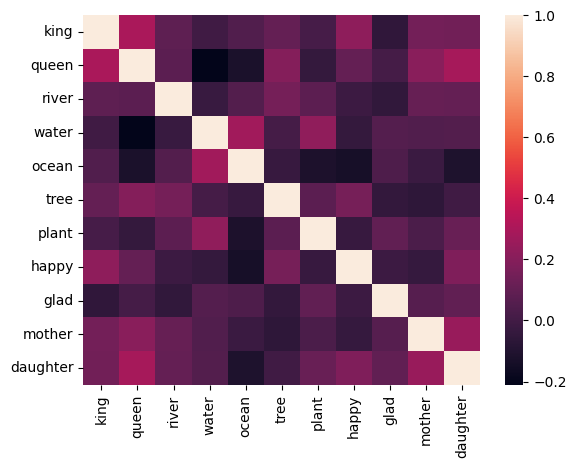

In [122]:
import seaborn as sns
sns.heatmap(df)

In [123]:
# Dimensionality Reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_word_vectors = pca.fit_transform(word_vectors)

In [124]:
import matplotlib.pyplot as plt

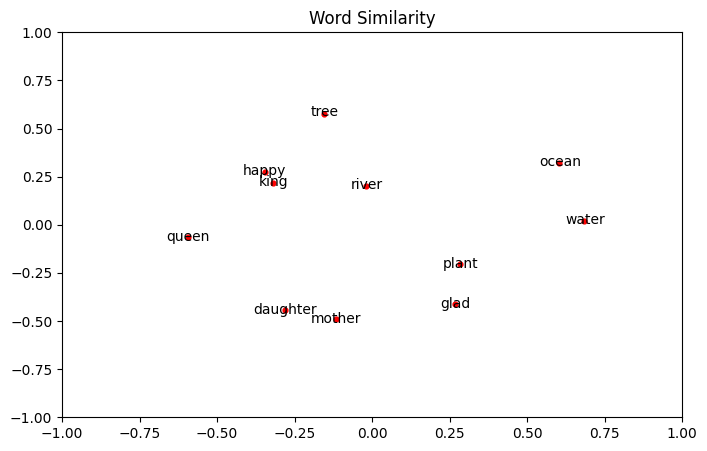

In [125]:
plt.figure(figsize=(8, 5))
plt.scatter(reduced_word_vectors[:, 0], reduced_word_vectors[:, 1], s = 12, color = "red")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title("Word Similarity")
x, y = reduced_word_vectors[:, 0], reduced_word_vectors[:, 1]
offset = 0.5
for i in range(len(x)):
    label = words[i]
    plt.annotate(label, (x[i], y[i]), xytext=(x[i] + offset, y[i] + offset),
                 textcoords = 'offset points', ha = 'center', va = 'center')

In [126]:
def get_top_similarity(word:str, top_n:int = 10):
    word_id = vocab[word]
    if word_id is None:
        print(f"{word} not found in vocab")
        return

    word_vector = word_embedding[word_id]
    word_vector = np.reshape(word_vector, (len(word_vector), 1))

    distance = np.matmul(word_embedding, word_vector).flatten()
    top_n_idx = np.argsort(-distance)[1:top_n+1]

    top_n_dict = {}
    for i in top_n_idx:
        similar_word = vocab.lookup_token(i)
        top_n_dict[similar_word] = distance[i]

    return top_n_dict

In [127]:
s = "king"
print(f"Top 5 Similar words for {s}")
print("Word            | Similarity")
print("----------------------------")
for word, similar_words in get_top_similarity(s).items():
    print(f"{word:10} \t| {similar_words.item():.3f}")

Top 5 Similar words for king
Word            | Similarity
----------------------------
kings      	| 0.446
bohemond   	| 0.440
ballala    	| 0.436
1793       	| 0.398
kamehameha 	| 0.396
gregory    	| 0.391
spain      	| 0.386
patriarch  	| 0.379
joyce      	| 0.374
blish      	| 0.369


### Analogy tests

Solving `A:B::C:_` <=> if A is similar to B, then C is similar to _.

In [128]:
def get_analogy( w1, w2, w3):

    emb1 = word_embedding[vocab[w1]]
    emb2 = word_embedding[vocab[w2]]
    emb3 = word_embedding[vocab[w3]]

    emb4 = emb1 - emb2 + emb3

    emb4 = np.reshape(emb4, (len(emb4), 1))
    dot_product = np.matmul(word_embedding, emb4).flatten()
    top_5 = np.argsort(-dot_product)[1:6]

    return top_5, dot_product

In [129]:
top_5, dot_product = get_analogy("king", "man","queen")
print("Top 5 words for analogy - king : man :: queen : ?")
print("Word             Similarity")
for i in top_5:
    print(f"{vocab.lookup_token(i):10} {dot_product[i]}")

Top 5 words for analogy - king : man :: queen : ?
Word             Similarity
queen      1.2773923873901367
patriarch  0.8195511102676392
scottish   0.7483762502670288
ganymede   0.7218871116638184
hudson     0.7167882919311523


### Measure Precision

In [130]:
# Downloading analogy dataset
os.system('wget -O data/analogy_data.txt "https://drive.google.com/uc?export=download&id=1jHx25dECegjtRKBB587nEfHiJesrH0g2"')

0

In [131]:
import random
random.seed(42)

def get_analogy_samples(file_path, num_samples = 5000):
    with open(file_path, 'r') as f:
        analogies = []
        for line in f:
            #print(line)
            parts = line.strip().split()

            if len(parts) == 4:
                analogies.append(parts)

        analogies = random.sample(analogies, min(num_samples, len(analogies)))
        print(f"Total Analogies : {len(analogies)}")
        return analogies

In [132]:
file_path = "data/analogy_data.txt"
analogy_data = get_analogy_samples(file_path)

Total Analogies : 5000


In [133]:
def get_word_idx(word):
    return vocab[word] if word in vocab else None

def get_precision(analogy_data):
    total = 0
    correct = 0

    for a,b,c,d in  analogy_data:
        a,b,c,d = a.lower(), b.lower(), c.lower(), d.lower()

        if not all([get_word_idx(w) for w in [a,b,c,d]]):
            continue

        top_5, _ = get_analogy(a, b, c)
        predicted_words = []

        for i in top_5:
            word = vocab.lookup_token(i)
            predicted_words.append(word)

        if d in predicted_words:
            correct += 1
        total += 1
    print(f"{correct} correct out of {total} total")
    precision = correct / total if total > 0 else 0
    return precision

In [134]:
precision = get_precision(analogy_data)
print("Analogy Precision : ", precision)
# Required training more epochs to get better results

26 correct out of 2787 total
Analogy Precision :  0.009329027628274129


### Comparision with Google word2vec

In [135]:
# Downloading analogy dataset
os.system('wget -O data/GoogleNews-vectors-negative300.bin "https://drive.google.com/uc?export=download&id=1jHx25dECegjtRKBB587nEfHiJesrH0g2"')

0

In [136]:
import bs4
import requests
import tqdm.auto as tqdm

def prepare_data(url, file_path):
    response = requests.get(url, stream=True)
    response.raise_for_status() # check for errors

    if 'html' in response.headers['Content-Type']:
        response = requests.get(url)
        soup = bs4.BeautifulSoup(response.text, features='lxml') # parse the HTML
        if form := soup.find('form', id = 'download-form'):
            id = form.select_one('input[name="id"]')['value']
            uuid = form.select_one('input[name="uuid"]')['value']
            data = {
                'id': id,
                'uuid': uuid,
                'export': 'download',
                'confirm': 't'
            }
            response = requests.get(soup.find('form')['action'], params = data, stream = True)
            response.raise_for_status()

    with open(file_path, 'wb+') as f:
        with tqdm.tqdm(
            total = int(response.headers["Content-Length"]),
            unit = 'B',
            unit_scale = True,
            unit_divisor = 1024,
        ) as pbar:
            for chunk in response.iter_content(chunk_size = 1024):
                f.write(chunk)
                pbar.update(len(chunk))
    print("Downloaded to", file_path)

In [137]:
drive_link = "https://drive.google.com/uc?export=download&id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg"
target_path = "data/GoogleNews-vectors-negative300.bin"

prepare_data(drive_link, target_path)

  0%|          | 0.00/3.39G [00:00<?, ?B/s]

Downloaded to data/GoogleNews-vectors-negative300.bin


In [138]:
from gensim.models import KeyedVectors

google_model = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True, limit=50000)

In [139]:
words = ['king', 'queen', 'river', 'water', 'ocean', 'tree', 'plant', 'happy', 'glad', 'mother', 'daughter']

def get_similarity_google(words):
    word_vectors = [google_model[word] for word in words]
    word_vectors = [w for w in word_vectors]

    norm = np.linalg.norm(word_vectors, axis=1, keepdims=True)
    normalized_word_vectors = word_vectors / norm

    similarity_matrix = np.dot(normalized_word_vectors, normalized_word_vectors.T)

    similarity = cosine_similarity(normalized_word_vectors)
    return word_vectors, similarity

In [140]:
gword_vectors, gsimilarity = get_similarity_google(words)
print(len(gword_vectors))
pd.DataFrame(gsimilarity, index = words, columns = words)

11


,king,queen,river,water,ocean,tree,plant,happy,glad,mother,daughter
king,1.000000,0.651096,0.086155,0.035606,0.065263,0.109141,0.057788,0.113239,0.063524,0.160052,0.148813
queen,0.651096,1.000000,0.103566,0.018264,0.099157,0.112222,0.088803,0.121214,0.082538,0.288445,0.305139
river,0.086155,0.103566,1.000000,0.576898,0.477181,0.230746,0.201330,0.073289,0.071341,0.131063,0.116944
water,0.035606,0.018264,0.576898,1.000000,0.471691,0.196022,0.271738,0.067675,0.085623,0.110723,0.079457
ocean,0.065263,0.099157,0.477181,0.471691,1.000000,0.141859,0.067005,-0.000511,0.014122,0.105623,0.081207
tree,0.109141,0.112222,0.230746,0.196022,0.141859,1.000001,0.265187,0.076933,0.105760,0.188985,0.173519
plant,0.057788,0.088803,0.201330,0.271738,0.067005,0.265187,0.999999,-0.010519,-0.000679,0.148805,0.092466
happy,0.113239,0.121214,0.073289,0.067675,-0.000511,0.076933,-0.010519,1.000000,0.740889,0.119672,0.152536
glad,0.063524,0.082538,0.071341,0.085623,0.014122,0.105760,-0.000679,0.740889,1.000000,0.125566,0.181102
mother,0.160052,0.288445,0.131063,0.110723,0.105623,0.188985,0.148805,0.119672,0.125566,1.000000,0.870624


<Axes: >

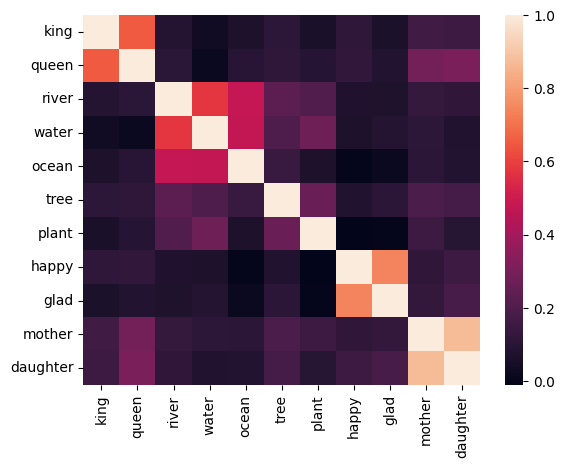

In [141]:
sns.heatmap(pd.DataFrame(gsimilarity, index = words, columns = words))

In [142]:
pca = PCA(n_components=2)
greduced_word_vectors = pca.fit_transform(gword_vectors)

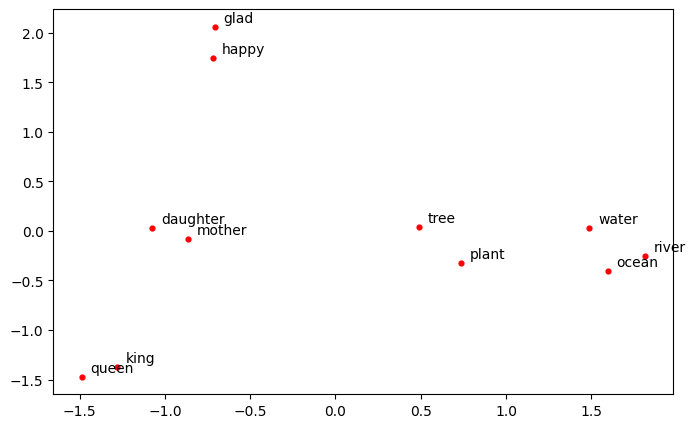

In [143]:
plt.figure(figsize=(8, 5))
x, y = greduced_word_vectors[:, 0], greduced_word_vectors[:, 1]
plt.scatter(x, y, s = 12, color = "red")
offset = 0.05
for i in range(len(x)):
    plt.annotate(words[i], xy = (x[i], y[i]), xytext = (x[i] + offset, y[i] + offset),)

In [144]:
google_model.most_similar("India")

[('Pakistan', 0.6706860661506653),
 ('Delhi', 0.6632035374641418),
 ('Bangalore', 0.6583030819892883),
 ('subcontinent', 0.6579218506813049),
 ('Bangladesh', 0.6527796983718872),
 ('sub_continent', 0.6503037810325623),
 ('Mumbai', 0.6495688557624817),
 ('Sri_Lanka', 0.6445952653884888),
 ('Chennai', 0.64213627576828),
 ('Hyderabad', 0.6390925645828247)]

In [145]:
def analogy_google(a, b, c):
    return google_model.most_similar(positive=[b, c], negative=[a], topn=5)

for i in analogy_google('man', 'king','woman'):
    print(f"{i[0]:10} {i[1]}")

queen      0.7118193507194519
monarch    0.6189674139022827
princess   0.5902431011199951
prince     0.5377321839332581
kings      0.5236844420433044


In [146]:
def precision_google(analogy_data):
    total = 0
    correct = 0
    for a,b,c,d in  analogy_data:
        a,b,c,d = a.lower(), b.lower(), c.lower(), d.lower()

        # Check if google_model contains the word
        if not all([w in google_model for w in [a,b,c,d]]):
            continue
        predicted_words = [i[0] for i in analogy_google(a, b, c)]
        if d in predicted_words:
            correct += 1
        total += 1
    print(f"{correct} correct out of {total} total")
    precision = correct / total if total > 0 else 0
    return precision

In [147]:
precision_google = precision_google(analogy_data)
print("Analogy Precision :-")
print("Model Precision        : ", precision)
print("Google Model Precision : ", precision_google)

4036 correct out of 4573 total
Analogy Precision :-
Model Precision        :  0.009329027628274129
Google Model Precision :  0.8825716160069976
